# Monte Carlo simulations


### Table of Contents

* [1. Simulating a stock price using geometric Brownian Motion](#chapter1)
* [2. Prcing of a European option ](#chapter2)
* [3. Prcing of American Options using LSMC ](#chapter3)

# 1. Simulating a stock price using geometric Brownian Motion <a class="anchor" id="chapter1"></a>

We recall that a geometric Brownian motion satisfies the following stochastic differential equation (SDE) under the Black-Scholes: $dS_t = \mu S_t dt + \sigma S_t dW_t $, with:<br>  
$S_t$ : Asset price <br>
$ \mu $ : The drift <br>
$ \sigma $ : The volatility of the asset price  <br>
$ W_t $ : Brownian motion  <br>

The closed form solution of the SDE is : 
$S(t) = S_0 e^{\left( \mu - \frac{1}{2} \sigma^2 \right) t + \sigma W_t}$ <br>

For the simulation we will use Euler's discretization with a finite horizon T. Using the property that $W$ has independent and normally distrubet increments we can write :
$$ 
S(t_{i+1}) = S(t_i) \exp \big( (\mu - \frac{1}{2} \sigma^2)(t_{i+1} - t_i) + \sigma \sqrt{t_{i+1} - t_i} Z_{i+1} \big),  
$$
for $i=0,1,...,T-1$ and $Z_i \sim \mathcal{N}(0,1)$

We use Monte Carlo methods and a GBM to *NVIDIA's* stock prices one month ahead using data from 2024, we will simulate the possible paths over January 2025

In [161]:
import numpy as np
import pandas as pd 
import yfinance as yf 

df = yf.download("AAPL",
                 start = "2023-01-01",
                 end = "2024-12-31")

print(df.head)

[*********************100%***********************]  1 of 1 completed

<bound method NDFrame.head of Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.632530  129.395518  122.742873  128.782649  112117500
2023-01-04  124.907707  127.181276  123.642420  125.431615   89113600
2023-01-05  123.583092  126.301485  123.326085  125.668841   80962700
2023-01-06  128.130234  128.792531  123.454601  124.561732   87754700
2023-01-09  128.654144  131.876686  128.397138  128.970474   70790800
...                ...         ...         ...         ...        ...
2024-12-23  254.989655  255.369227  253.171646  254.490204   40858800
2024-12-24  257.916443  257.926411  255.009620  255.209412   23234700
2024-12-26  258.735504  259.814335  257.347047  257.906429   27237100
2024-12-27  255.309296  258.415896  252.782075  257.546826   42355300
2024-12-30  251.923019  253.221595  250.474615  251.952985  

<Axes: title={'center': "Apple's returns"}, xlabel='Date'>

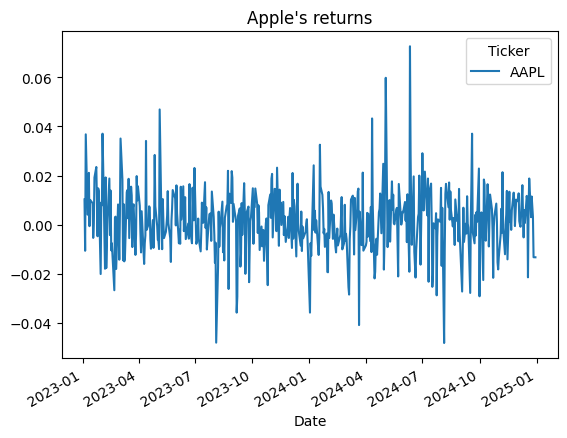

In [162]:
returns = df["Close"].pct_change()
returns.plot(title = "Apple's returns")

In [163]:
train = returns.loc["2023"]
test = returns.loc["2024"]


In [164]:
T = len(test) #nb de jours 
N = len(test) #nb de pas de temps (journaliers)
N_SIM = 100 #nb de simulations 
mu = train.mean().item()    
sigma = train.std().item()  
S_0 = df.loc[train.index[-1], "Close"].item() 


In [165]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                  random_seed=42):
    np.random.seed(random_seed)
    
    dt = T/N #incrément de tmps 
    dW = np.random.normal(scale=np.sqrt(dt), size=(n_sims, N)) #on crée un tableau de lois normales ligne = nb simulation, colonnes = nb pas de temps
    W = np.cumsum(dW, axis=1) #on fait une somme cumulée par colonne
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = (
        s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)
    )
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

In [166]:
gbm_simulations =simulate_gbm(S_0, mu, sigma,N_SIM, T, N)
sim_df = pd.DataFrame(np.transpose(gbm_simulations),
                      index=train.index[-1:].union(test.index))
print(sim_df.head())
res_df = sim_df.mean(axis = 1).to_frame()
print(res_df.head())
res_df = res_df.join(df["Close"])
res_df.columns = ["simulation_average", "ajd_close_price"]


                    0           1           2           3           4   \
Date                                                                     
2023-12-29  191.380966  191.380966  191.380966  191.380966  191.380966   
2024-01-02  192.918087  193.942075  188.376360  194.273370  193.407364   
2024-01-03  192.921547  199.535284  190.047560  192.306070  194.707945   
2024-01-04  194.840450  202.497017  188.830855  199.125113  197.257361   
2024-01-05  198.955567  199.015460  188.007978  200.715864  199.188048   

                    5           6           7           8           9   ...  \
Date                                                                    ...   
2023-12-29  191.380966  191.380966  191.380966  191.380966  191.380966  ...   
2024-01-02  188.824251  193.402901  194.027450  193.312627  192.197357  ...   
2024-01-03  193.175085  196.083336  198.347789  195.948123  193.595029  ...   
2024-01-04  194.536532  196.646353  202.007833  192.365796  194.923355  ...   
2024-01

<Axes: title={'center': "Simulation's results of Apple's Stock Price"}, xlabel='Date'>

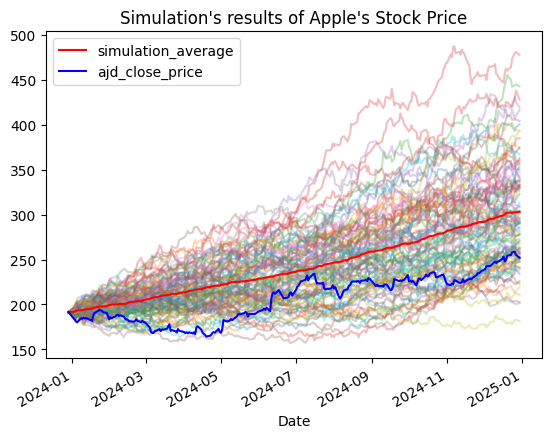

In [167]:
ax = sim_df.plot(
    alpha=0.3, legend=False, title="Simulation's results of Apple's Stock Price"
)
res_df.plot(ax=ax, color = ["red", "blue"])

# 2. Pricing of a European Option <a class="anchor" id="chapter2"></a>

We recall the Black-Scholes formula for a European Call denoted $C(S_t,t)$ : 
$$
C(S_t,t) = N(d_1)S_t - N(d_2)Ke^{-r(T-t)}
$$
where $d_1 = \frac{1}{\sigma \sqrt{T - t}} \left[ \ln \left(\frac{S_t}{K}\right) + \left( r + \frac{\sigma^2}{2} \right)(T - t) \right]$
and $d_2 = d_1 - \sigma \sqrt{T - t}$
and $N(.)$ stands for the cdf of the Standard Normal distribution.

In [168]:
from scipy.stats import norm
import numpy as np

We define the parameters for the valuation :

In [169]:
S_0 = 100 #price at time 0 
K = 100 #strike
r = 0.05 #free risk rate
sigma = 0.5 
T = 1 
N = 252
dt = T/N
N_SIMS = 1_000_000
discount_factor = np.exp(-r*T)

we now define the formula :

In [170]:
def black_scholes(S_0,K,T,r,sigma,type = 'call'):
    d1 = (np.log(S_0/K) + (r+(sigma**2)/2)**T)/sigma*np.sqrt(T)
    d2 = d1 - sigma*np.sqrt(T)
    if type == 'call':
        N_d1 = norm.cdf(d1,0,1)
        N_d2 = norm.cdf(d2,0,1)
        val = N_d1*S_0 - N_d2*K*np.exp(-r*T)
    elif type == 'put':
        N_d1 = norm.cdf(-d1,0,1)
        N_d2 = norm.cdf(-d2,0,1)
        val = -N_d1*S_0 + N_d2*K*np.exp(-r*T)
    else : 
        raise ValueError("Wrong input for type!")
    
    return float(val) 



we now valuate a call optino using the previous parameters : 

In [171]:
black_scholes(S_0,K,T,r,sigma,type = 'call')

21.79260421286685

We simulate the stock price using the previous function for GBM

In [172]:
gbm_sims = simulate_gbm(S_0,r, sigma,N_SIMS, T, N)


In [173]:
premium = discount_factor*np.mean(np.maximum(0,gbm_sims[:,-1]-K))
print(premium)

21.731937527394578


However, as we are only interested in the price of the stock at time T, we can also use the formula :
$S(t) = S_0 e^{\left( \mu - \frac{1}{2} \sigma^2 \right) t + \sigma W_t}$ instead of simulating all paths

In [174]:
def options_simulations(S_0,K,T,r,sigma,n_sims, type = 'call',random_seed =  42):
    np.random.seed(random_seed)
    W_T = np.random.normal(0,1,size = n_sims)
    S_T = S_0*np.exp((r-0.5*sigma**2)*T+ sigma * W_T*np.sqrt(T))
    if type == 'call':
        price = discount_factor * np.mean(np.maximum(0,S_T - K))
    elif type == 'put':
        price = discount_factor * np.mean(np.maximum(0,K-S_T))
    else :
        raise ValueError("Wrong input for type!")
    return float(price)


In [175]:
options_simulations(S_0,K,T,r,sigma,N_SIMS, type = 'call',random_seed =  42)

21.74555751638447

We thus have a better approximation, closer to the value given by the black scholes formula 

# 3. Pricing of American Options using Least Squares Monte Carlo (LSMC) <a class="anchor" id="chapter3"></a>

Let us consider an American option, meaning the option can be exercised at any time $t$. <br>

To valuate the option's price, as we can't look only look at the terminal value, we use LSMC approach (introduced by Longstaff & Scwharz).

We discretize the interval $[0,T]$ (where $T$ is the maturity) into a finite number of equally spaced intervals such that the early exercise can only happen at those time steps. <br>

Let us denote $C_t(s)$ the continuation value such that $ C_t(s) = \mathbb{E}_t^Q \left[ e^{-r \, \delta t} \, V_{t+\delta t}(S_{t+\delta t}) \mid S_t = s \right] $ <br>
$C_t(s)$ represents the option's price if we do not exercise the option at time t but wait the next step.

Let us denote $h_t(s)$ the option's premium if it is exercised immediately e.g. for a Call option $h_t(s) = (S_t - K)_+$

Thus we have $V_t(s) = max(h_t(s),C_t(s))$


In [203]:
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


In [204]:
np.random.seed(42)


We define the option's parameters

In [205]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50
dt = T / N
N_SIMS= 10**6
discount_factor = np.exp(-r * dt)
OPTION_TYPE = "put"
POLY_DEGREE = 4
poly = PolynomialFeatures(degree = POLY_DEGREE)

We simulate the stock price using the GBM simulations : 

In [206]:
stock_price = simulate_gbm(S_0,r,sigma,N_SIMS,T,N,random_seed = 42)
#stock_price[:,-1] represents the stock price at time T 


In [207]:
payoff_matrix = np.maximum(K-stock_price,np.zeros_like(stock_price))
value_matrix = np.zeros_like(stock_price) #this represents V_t
value_matrix[:,-1] = payoff_matrix[:,-1] #at time T, V_T = (K - S_T)_+ 
print(stock_price[:,1].reshape(-1,1))

[[36.53855982]
 [36.36058715]
 [34.61496865]
 ...
 [36.15354128]
 [37.07440179]
 [36.9574048 ]]


We then iterate backwards : 

In [209]:
model = LinearRegression()
for t in range(N-1,-1,-1): #we do a backwards for loop 
    X = stock_price[:, t].reshape(-1, 1)
    regression = poly.fit_transform(X)

    y = value_matrix[:,t+1]*discount_factor
    
    model.fit(regression,y)
    continuation_value = model.predict(regression)
    value_matrix[:,t] = np.where(
        payoff_matrix[:,t]>continuation_value,
        payoff_matrix[:,t],
        continuation_value
        )
    
    

In [217]:
option_premium = np.mean(value_matrix[:, 0] * discount_factor)
print("Premium:",option_premium)


Premium: 4.725040998195479


In [211]:
options_simulations(S_0,K,T,r,sigma,N_SIMS, type = 'put',random_seed =  42)

4.0845173926068945

We see that the premium of an American put option is higher than the premium of a European put option.